In this notebook, I examine the provided data for Kaggle's Humpback Whale ID challenge. I also look at data augmentations in an attempt to inflate the size of the training dataset.

In [137]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import sys
import shutil
import random
import imageio

from six.moves import cPickle as pickle

from tqdm import tqdm

%matplotlib inline

In [10]:
import zipfile as zp

path_to_file='../data/train.zip'
directory_to_extract='../data/train_images'
zip_ref = zp.ZipFile(path_to_file, 'r')
zip_ref.extractall(directory_to_extract)
zip_ref.close()

In [4]:
INPUT_DIR = '../data/train_images/train/'

In [12]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(INPUT_DIR+filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)

def plot_images_in_dir(filenames, labels, directory='', rows=4):
    imgs = [plt.imread(directory+'/'+filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

In [13]:
np.random.seed(42)

## Exploring the dataset

In [2]:
train_df = pd.read_csv('../data/train.csv')
train_df.head(10)

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0031c258.jpg,new_whale
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782


Let's plot a couple of images at random.

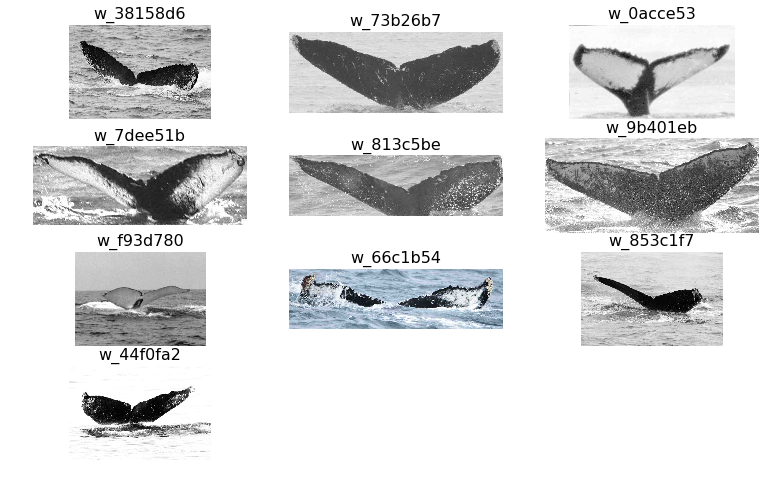

In [15]:
rand_rows = train_df.sample(frac=1.)[:10]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

The competition states that it's hard because: "there are only a few examples for each of 3,000+ whale ids", so let's take a look at the breakdown of number of image per category.

In [16]:
num_categories = len(train_df['Id'].unique())
     
print('Number of categories: '+str(num_categories))

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

In [17]:
size_buckets = Counter(train_df['Id'].value_counts().values)

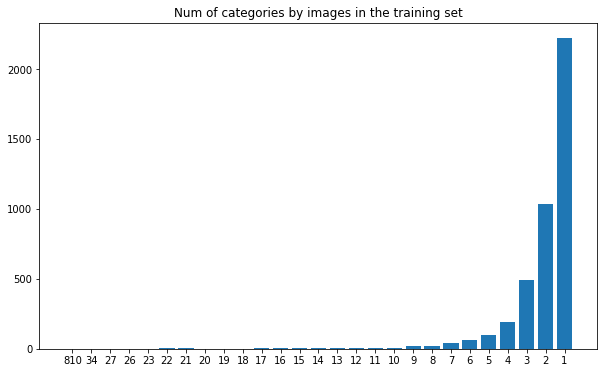

In [18]:
plt.figure(figsize=(10, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")

plt.show()

As we can see, the vast majority of classes only have a single image in them. This is going to make predictions very difficult for most conventional image classification models.

In [19]:
train_df['Id'].value_counts().head(20)

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_693c9ee     22
w_fd1cb9d     22
w_ab4cae2     22
w_43be268     21
w_73d5489     21
w_987a36f     21
w_f19faeb     20
w_9b401eb     19
w_95874a5     19
w_c0d494d     18
w_b7d5069     18
w_dbda0d6     17
w_0e737d0     17
w_eb0a6ed     17
w_18eee6e     17
Name: Id, dtype: int64

In [20]:
total = len(train_df['Id'])
print('Total images in training set '+str(total))

Total images in training set 9850


New whale is the biggest category with 810, followed by `w_1287fbc`. New whale, I believe, is any whale that isn't in scientist's database. Since we can pick 5 potential labels per id, it's probably going to make sense to always include new_whale in our prediction set, since there's always an 8.2% change that's the right one. Let's take a look at one of the classes, to get a sense what flute looks like from the same whale.

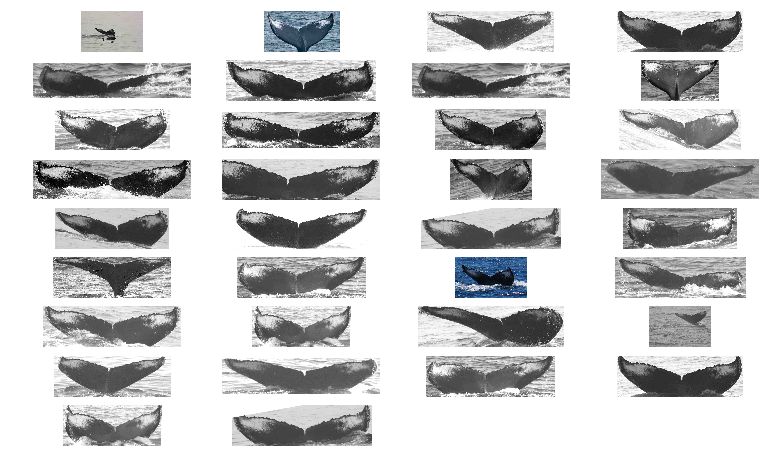

In [21]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_images_for_filenames(list(w_1287fbc['Image']), None, rows=9)

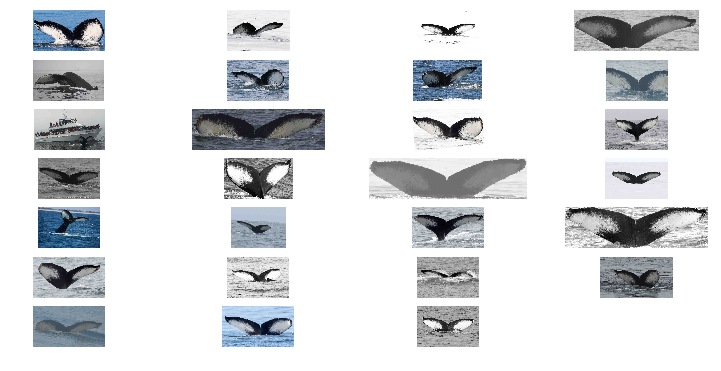

In [22]:
w_98baff9 = train_df[train_df['Id'] == 'w_98baff9']
plot_images_for_filenames(list(w_98baff9['Image']), None, rows=9)

It's very difficult to build a validation set when most classes only have 1 image, so my thinking is to perform some aggressive data augmentation on the classes with < 10 images before creating a train/validation split. Let's take a look at a few examples of whales with only one example.

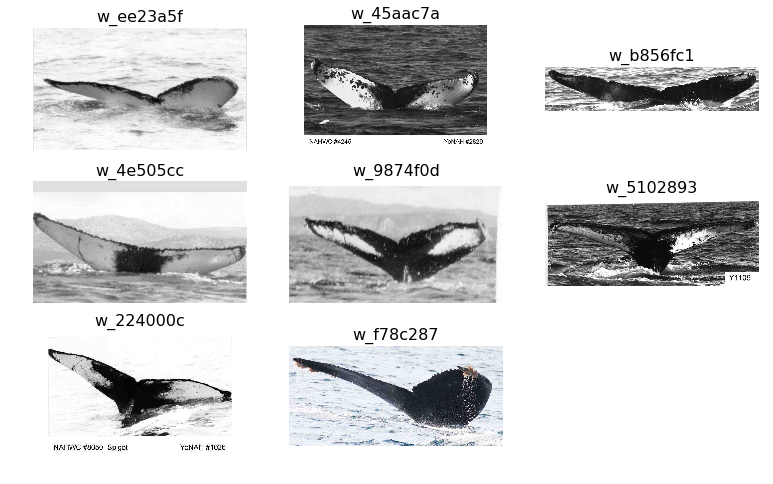

In [23]:
one_image_ids = train_df['Id'].value_counts().tail(8).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(train_df[train_df['Id'] == i]['Image']))
    labels.append(i)
    
plot_images_for_filenames(one_image_filenames, labels, rows=3)

From these small sample sizes, it seems like > 50% of images are black and white, suggesting that a good initial augementation might be to just convert colour images to greyscale and add to the training set. Let's confirm that by looking at a sample of the images.

In [24]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [25]:
is_grey = [is_grey_scale(INPUT_DIR+str(i)) for i in train_df['Image'].sample(frac=0.1)]
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(' of grey images: '+grey_perc)

KeyboardInterrupt: 

It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

In [ ]:
img_sizes = Counter([Image.open('{INPUT_DIR}/train/{i}').size for i in train_df['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Data Augmentation 

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

data_augment_path = '../data/dataAugment'

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

if not os.path.exists(data_augment_path):
    os.makedirs(data_augment_path)

img = load_img(INPUT_DIR+'/ff38054f.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print('Image size: '+str(x.shape))
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=data_augment_path, save_prefix='whale', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Image size: (748, 1050, 3)


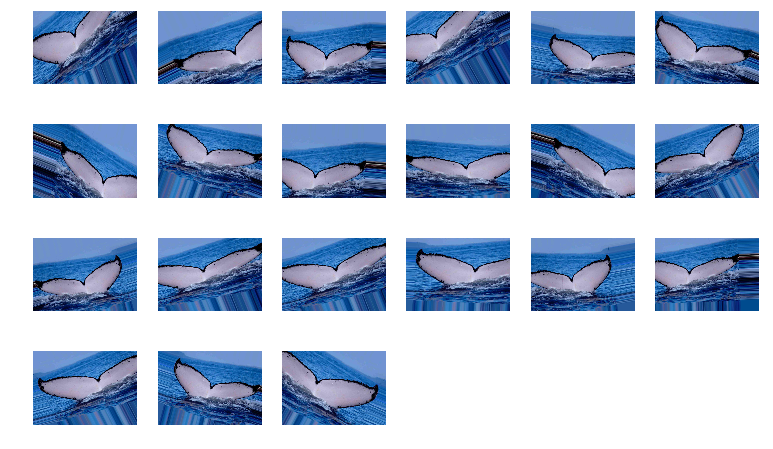

In [29]:
images = os.listdir('../data/dataAugment')

plot_images_in_dir(images, None, '../data/dataAugment', rows=4)

Now it is time to look at the image sizes

In [30]:
image_dir='../data/train_images/train'
train_images = os.listdir(image_dir)
height = []
width = []
print('Total number of images: '+str(len(train_images)))
img = load_img(image_dir+'/'+train_images[1])  # this is a PIL image
x = img_to_array(img) 
print(x.shape)
for image in train_images:
    img = load_img(image_dir+'/'+image)  # this is a PIL image
    x = img_to_array(img)
    height.append(x.shape[0])
    width.append(x.shape[1])
     

Total number of images: 9850
(700, 1050, 3)


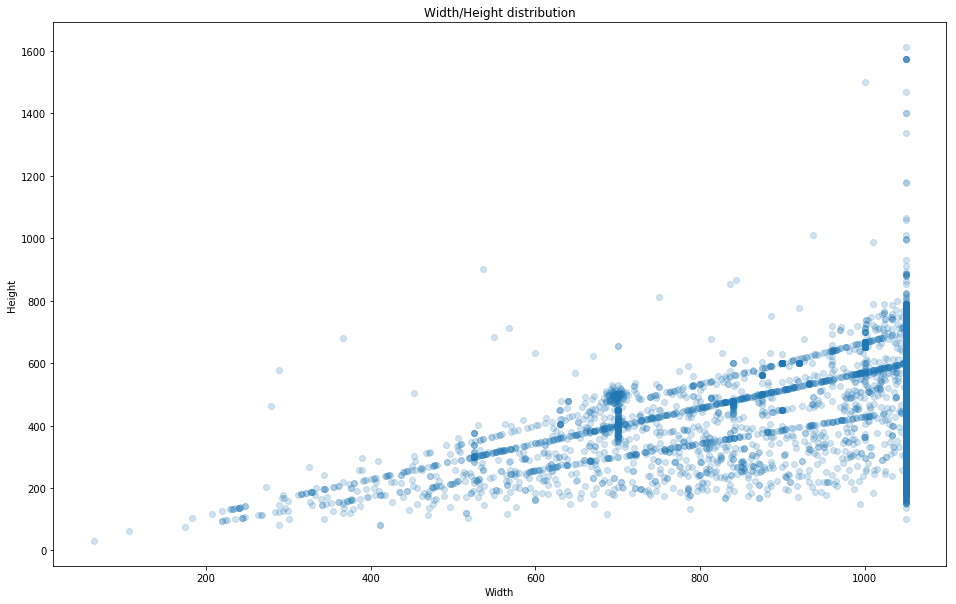

In [31]:
plt.figure(figsize=(16, 10))
plt.title('Width/Height distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(width, height, alpha=.2)
plt.show()

### We are going to find out the average aspect ratio

The average aspect ratio is: 2.2622


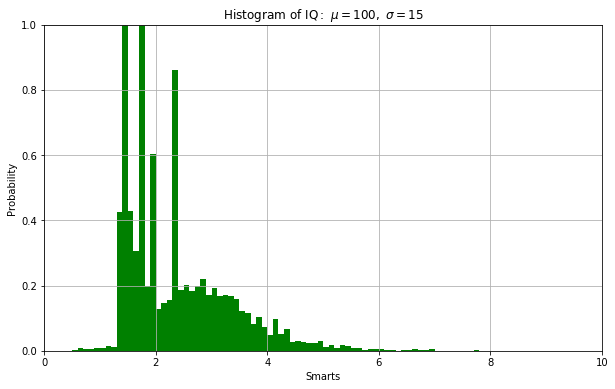

In [32]:
width = np.asarray(width, dtype=np.float32)
height = np.asarray(height, dtype=np.float32)
aspectratio = width/height
print('The average aspect ratio is: '+str(np.mean(aspectratio)))

plt.figure(figsize=(10, 6))

# the histogram of the data
n, bins, patches = plt.hist(aspectratio, 100, normed=1, facecolor='green')

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([0, 10, 0, 1])
plt.grid(True)

plt.show()

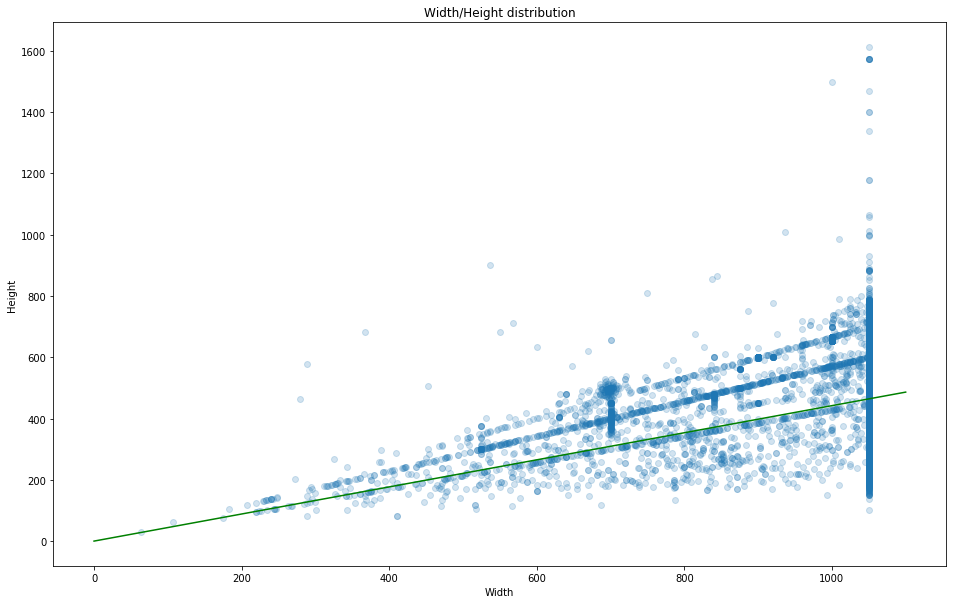

In [33]:
plt.figure(figsize=(16, 10))
plt.title('Width/Height distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(width, height, alpha=.2)
line_x_range = (0, 1100)
plt.plot(line_x_range, [ a * 1/np.mean(aspectratio) for a in line_x_range], "g", alpha=1)
plt.show()

In [34]:
def compute_pairs(n):
    pairs = 0
    for pair in range(1,n-1):
        pairs += pair
        
    return pairs

pictures_in_class = 15
print('For '+str(pictures_in_class)+' pictures in class there are '+str(compute_pairs(pictures_in_class))+' pairs.')

For 15 pictures in class there are 91 pairs.


In [36]:
#Create ordered test folder
newpath = '../data/train_ordered'
if not os.path.exists(newpath):
    os.makedirs(newpath)
# Creating a folder for each whale id
#New folder names set
folder_ids = set(train_df['Id'].values.tolist())
for folder_id in folder_ids:
    new_path_folder = newpath+'/'+folder_id
    if not os.path.exists(new_path_folder):
        os.makedirs(new_path_folder)
    images = train_df[train_df['Id'] == folder_id]['Image'].values.tolist()
    for image in images:
        full_file_name = os.path.join('../data/train_images/train', image)
        if (os.path.isfile(full_file_name)):
            shutil.copy(full_file_name, new_path_folder)

In [6]:
newpath = '../data/train_ordered'
source_dir = '../data/train_images/train'

def copy_images_to_dir(images, source_dir, destination_dir, maximum=0):
    for index, image in enumerate(images):
            full_file_name = os.path.join(source_dir, image)
            if (os.path.isfile(full_file_name)):
                shutil.copy(full_file_name, destination_dir)
            if (maximum != 0) and index >= maximum-1:
                return
            
def copy_images_to_dir_expand(images, source_dir, destination_dir, maximum=0, minimum=0):
    copy_images_to_dir(images, source_dir, destination_dir, maximum)
    if minimum != 0 and len(images) < minimum:
        for index in range(1,minimum - len(images)):
            image_ex = load_img(os.path.join(source_dir, random.choice(images)))  # this is a PIL image
            x = img_to_array(image_ex)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=destination_dir, save_prefix='exp_', save_format='jpeg'):
                break  # otherwise the generator would loop indefinitely
                    
def generate_file_structure(root_path, source_dir=None, maximum=0, minimum=0):
    progress = 0
    print('Progress '+str(progress)+' %')
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    # Creating a folder for each whale id
    #New folder names set
    folder_ids = set(train_df['Id'].values.tolist())
    for index, folder_id in enumerate(folder_ids):
        new_path_folder = os.path.join(root_path, folder_id)
        if not os.path.exists(new_path_folder):
            os.makedirs(new_path_folder)
        if source_dir is not None:
            images = train_df[train_df['Id'] == folder_id]['Image'].values.tolist()
            copy_images_to_dir_expand(images, source_dir, new_path_folder, maximum, minimum)
        if(round(100*float(index)/float(len(folder_ids))) > progress):
            print('Progress '+str(round(100*float(index)/float(len(folder_ids))))+' %')
        progress = round(100*float(index)/float(len(folder_ids)))

### Conversion from RBG to Greyscale
The following function will take an image and, if it is in RGB, will aplly a conversion from RGB to greyscale

In [54]:
#Weights RGB used for image convesion to greyscale
R_WEIGHT = 0.299
G_WEIGHT = 0.587
B_WEIGHT = 0.114
#Target size in pixels for reshape
DATASET_HEIGHT = 44
DATASET_WIDTH = 100

In [152]:
#input is a file path that should point to an image file.
#output is the Greyscale version of that image.
def convert_image_to_greyscale(image_path, verbose = False):
    #Read image from given filepath and also print its shape for information
    image = imageio.imread(image_path)
    if verbose:
        print("Image shape = {}".format(image.shape))
    
    # init 2D numpy array thay will contained the greyscale image to return
    grey = np.zeros((image.shape[0], image.shape[1])) 
    
    #detect if provided image is already in greysaale (Assumption is that there is only one 
    #layer, so shape[2] not existent). If so, return the input as output.
    if len(image.shape) < 3 :
        if verbose:
            print("Image {} is already in Greyscale.".format(image_path) )
        return image
    #If image shape[2] is 3 (asume RGB) we will convert it to gresycale. If shape[2] exists but reports 1
    # then we detect it and return the input image as an output.
    # if shape[2] its not 3 nor 1 we will raise an exception due to invalid value
    try:
        assert( image.shape[2] == 3 )
        assert( 1.01 > (R_WEIGHT + G_WEIGHT + B_WEIGHT) > 0.99 ) #Ensure weights are valid, they add up to 1.0
        grey = R_WEIGHT * image[:,:, 0] + G_WEIGHT * image[:,:, 1] + B_WEIGHT * image[:,:, 2]
    except AssertionError:
        if image.shape[2] == 1:
            if verbose:
                print("Image {} is already in Greyscale.".format(image_path) )
            grey = image
        else:
            raise ValueError("Image {} is not in RGB format nor in Greyscale. It has {} layers. Please \
              double check.".format(image_path, image.shape[2]))
    return grey

#### Resize image to desried size
The following function will take a np vector representing a greyscale image and resize it to a desired size.

For Resample:
- Image.NEAREST (use nearest neighbour)
- Image.BILINEAR (linear interpolation) 
- Image.BICUBIC (cubic spline interpolation)
- Image.LANCZOS (a high-quality downsampling filter)
If omitted, or if the image has mode “1” or “P”, it is set PIL.Image.NEAREST.

In [56]:
#input a greyscale np representing an image
#output a greyscale np representing theinput image rechaped to different dimensions
def resize_image(image_np):
    _img = Image.fromarray(image_np) 
    _img = _img.resize( (DATASET_WIDTH , DATASET_HEIGHT) , Image.BILINEAR )
    assert(_img.size[0] == DATASET_WIDTH)
    assert(_img.size[1] == DATASET_HEIGHT)
    return np.array(_img.getdata(), np.uint8).reshape(_img.size[1], _img.size[0])
    

Let's test the functions resize_image and convert_image_to_greyscale

Converting image ../data/train_balanced/w_deb33de/2029e9b6.jpg :


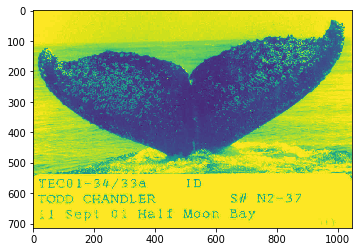

Image shape = (714, 1046)
Image ../data/train_balanced/w_deb33de/2029e9b6.jpg is already in Greyscale.


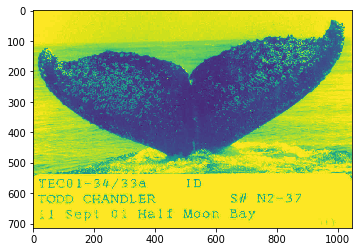

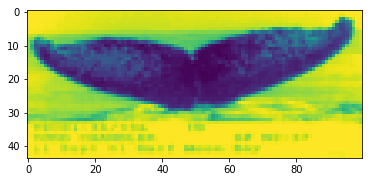

(44, 100)


In [80]:
path = "../data/train_balanced/w_deb33de/"
im_file = path + random.choice(os.listdir(path))
print("Converting image {} :".format(im_file))

image = imageio.imread(im_file)
plt.imshow(image) #load
plt.show() 

image_grey = convert_image_to_greyscale(im_file, True)
_image_grey = Image.fromarray(image_grey)
_image_grey.show()
plt.imshow(image_grey) #load
plt.show() 

image_final = resize_image(image_grey)
_image_final = Image.fromarray(image_final)
_image_final.show()
plt.imshow(image_final) #load
plt.show() 
print(image_final.shape)

In [81]:
print(train_df['Id'].values.tolist()[50])
id_wale = train_df['Id'].values.tolist()[50]
#print(train_df)
print(train_df[train_df['Id'] == id_wale]['Image'].values.tolist())


new_whale
['0031c258.jpg', '007c3603.jpg', '00863b8c.jpg', '00aa021c.jpg', '00ad9219.jpg', '00ded600.jpg', '012621f1.jpg', '01cf2e2e.jpg', '02715625.jpg', '02aceb16.jpg', '036b9b64.jpg', '037e59bc.jpg', '03933dbb.jpg', '03c6a5c0.jpg', '03de1a54.jpg', '04a39247.jpg', '04ad14b2.jpg', '04d7f905.jpg', '051e6fbe.jpg', '0524950b.jpg', '053555fe.jpg', '0592e297.jpg', '05a273d8.jpg', '05e50d1a.jpg', '05ee4ba3.jpg', '05f4fd87.jpg', '06194c8f.jpg', '06e622e0.jpg', '07b8a5e7.jpg', '07ecc5ba.jpg', '086cc275.jpg', '08b62734.jpg', '09394b01.jpg', '094a67d1.jpg', '0a00c8c5.jpg', '0ada5fa1.jpg', '0aed1250.jpg', '0b635230.jpg', '0bfb2b72.jpg', '0c11fa0c.jpg', '0c88a7aa.jpg', '0c8983f3.jpg', '0cd6cc7b.jpg', '0d10de68.jpg', '0d482f6b.jpg', '0df85a56.jpg', '0e5996a4.jpg', '0e6ac93b.jpg', '0f550bb8.jpg', '0fa288cf.jpg', '0fb6482b.jpg', '0fd95216.jpg', '0ffa7cf0.jpg', '104713f3.jpg', '104ef864.jpg', '10807a6e.jpg', '109d1dc5.jpg', '10ae4f14.jpg', '10bd94ea.jpg', '10f81763.jpg', '10ffe6f7.jpg', '112a66fb.jpg

#Data processing

In [145]:
#Balance dataset
min_n_per_class = 100
max_n_per_class = 200
path_train_balanced = '../data/train_balanced'
source_dir = '../data/train_images/train'
generate_file_structure(path_train_balanced, source_dir, max_n_per_class, min_n_per_class)

Progress 0 %
Progress 1.0 %
Progress 2.0 %
Progress 3.0 %
Progress 4.0 %
Progress 5.0 %
Progress 6.0 %
Progress 7.0 %
Progress 8.0 %
Progress 9.0 %
Progress 10.0 %
Progress 11.0 %
Progress 12.0 %
Progress 13.0 %
Progress 14.0 %
Progress 15.0 %
Progress 16.0 %
Progress 17.0 %
Progress 18.0 %
Progress 19.0 %
Progress 20.0 %
Progress 21.0 %
Progress 22.0 %
Progress 23.0 %
Progress 24.0 %
Progress 25.0 %
Progress 26.0 %
Progress 27.0 %
Progress 28.0 %
Progress 29.0 %
Progress 30.0 %
Progress 31.0 %
Progress 32.0 %
Progress 33.0 %
Progress 34.0 %
Progress 35.0 %
Progress 36.0 %
Progress 37.0 %
Progress 38.0 %
Progress 39.0 %
Progress 40.0 %
Progress 41.0 %
Progress 42.0 %
Progress 43.0 %
Progress 44.0 %
Progress 45.0 %
Progress 46.0 %
Progress 47.0 %
Progress 48.0 %
Progress 49.0 %
Progress 50.0 %
Progress 51.0 %
Progress 52.0 %
Progress 53.0 %
Progress 54.0 %
Progress 55.0 %
Progress 56.0 %
Progress 57.0 %
Progress 58.0 %
Progress 59.0 %
Progress 60.0 %
Progress 61.0 %
Progress 62.0 %
Prog

In [146]:
animals = ['dog', 'cat', 'elephant', 'pig']
print(len(animals))
print(random.choice(animals))
for index, animal in enumerate(animals):
    print('Animal number '+str(index)+' is '+animal)

4
cat
Animal number 0 is dog
Animal number 1 is cat
Animal number 2 is elephant
Animal number 3 is pig


#### Whale_id.pckle creation
Lets iterate through all folders to transform images and save pickle for later use

In [194]:
#Input: np to pickle
#Actions: save input in a .pickle file in desired folder
#Output successful
def maybe_pickle(dest_dir, dataset, file_name, force=False):
    _success = True
    _msg = "No action"
    _set_filename = file_name + '.pickle'
    _file_path = os.path.join(dest_dir, _set_filename)
    if os.path.exists(_file_path) and not force:
        # You may override by setting force=True.
        _msg = '{} already present - Skipping pickling.'.format(_set_filename)
    else:
        try:
            with open(_file_path, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                _msg = "Success"
        except Exception as e:
            _msg = 'Unable to save data to {} : {}'.format(_set_filename, e)
            _success = False
    return _success, _msg
        
#Input: Root path where all subfolders are stored
#Actions: Reshape images and do pickle in every subfolder
def resize_and_pickle_images_in_dir(root_path, verbose = False):  
    _progress = 0
    _prev_progress = 0
    print("Progress {}%: ".format(_progress))
    #Make sure the path exist before executing the next steps.
    if not os.path.exists(root_path):
        raise ValueError("Path {} idoes not exist.".format(root_path) )
     
    # get all files' and folders' names in the current directory
    _filenames= os.listdir(root_path) 
    _sub_folders = []
    # loop through all the files and folders and check whether the current object is a folder or not
    for filename in _filenames: 
        _path = os.path.join(os.path.abspath(root_path), filename)
        # if it is a directory add it to subdirectories list
        if os.path.isdir(_path): 
            _sub_folders.append(_path)
    
    #Obtain number of subfolders for further checking and progress monitoring
    _total_folders = len(_sub_folders)
    
    #Loop through all subfolders
    for ix ,folder in enumerate(_sub_folders):
        _image_list = [f for f in os.listdir(folder) if (f.endswith('.jpg') or f.endswith('.jpeg'))]
        if verbose:
            print("In folder {} found {} images.".format( folder , len(_image_list)) )
            
        #Create empty np (intended) to store all processed image of a specific folder
        _image_concentrator = np.ndarray(shape = ( len(_image_list) , DATASET_HEIGHT, DATASET_WIDTH))
        #Loop through all images in a subfolder and reshape them. Save the reshaped in a np placeholder that will be saved in a pickle file
        for num, image_file in enumerate(_image_list):
            _image_path = os.path.join(os.path.abspath(folder), image_file)
            _image_concentrator[num , : , :] = resize_image( convert_image_to_greyscale(_image_path, verbose) ) 
            
        #Perform some checks before apply pickle
        assert(len(_image_list) == _image_concentrator.shape[0])
        
        #Output information
        if verbose:
            print("Reshaped and stored the {} images from folder {}".format( \
                                                    _image_concentrator.shape[2] , folder) )
        #Let's save the np as a .pickle:
        _success, _msg = maybe_pickle(folder, _image_concentrator,  os.path.basename(folder), force=False)
        if verbose:
            print("Pickle folder {} with message: ".format( folder) + _msg)
        #Now we make sure the operation was successful:
        if not _success:
            print("ERROR occurred in maybe_pickle: " + _msg)
        
        #Monitor Progress
        _progress = ((100 * ix /_total_folders)  )
        if ( _progress% 3 == 0) and (_progress > _prev_progress):
            _prev_progress = _progress
            print("Progress {}%".format( 100 * ix /_total_folders))
     
    ###REMEMBER TO NORMALIZE BEFORE PICKLE
    print("Progress 100%")    
    return

resize_and_pickle_images_in_dir(path_train_balanced , True)

Progress 0%: 
In folder /root/Kaggle/whale/data/train_balanced/w_deb33de found 98 images.
Image shape = (714, 1046, 3)
Image shape = (338, 1050, 3)
Image shape = (240, 420, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 1046, 3)
Image shape = (338, 1050, 3)
Image shape = (240, 420, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 1046, 3)
Image shape = (240, 420, 3)
Image shape = (240, 420, 3)
Image shape = (240, 420, 3)
Image shape = (240, 420, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 1046, 3)
Image shape = (240, 420, 3)
Image shape = (240, 420, 3)
Image shape = (338, 1050, 3)
Image shape = (714, 1046, 3)
Image shape = (338, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (240, 420, 3)
Image shape = (338, 1050, 3)
Image shape = (240, 420, 3)
Image shape = (714, 1046, 3)
Image shape = (240, 420, 3)
Image shape = (338, 1050, 3)
Image shape = (714, 1046, 3)
Image shape = (714, 10

KeyboardInterrupt: 

In [203]:
pixel_depth = 255.0  # Number of levels per pixel.

def get_normalized_whale_images(pickle_file_path, verbose):
    ''' Input: file path to a .pickle
        Output: np vector containing all NORMALIZED and RESHUFFLED images of that pickle.'''
    # Open pickle file
    try:
        f = open(pickle_file_path, 'rb')
        _load = pickle.load(f)
        if verbose:
            print("Loaded file " + pickle_file_path)
        #Reshuffle numpy
        np.random.shuffle(_load)
        #Normalize image  to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
        _normalized = (_load - pixel_depth / 2) / pixel_depth
        if verbose:
            print("Raw value  Example: {}".format( _load[0,:,:]))
            print("Normalized images Example: {}".format( _normalized[0,:,:]))
        f.close() 
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
        
    return _normalized

pickle_load = get_normalized_whale_images(os.path.join('../data/train_balanced/w_d6d502a', 'w_d6d502a.pickle'), False)

In [204]:

def generate_positive_pairs( whale_id_images ):
    _list_size = len(whale_id_images)
    print(len(whale_id_images))
    print(whale_id_images.shape[0])
    return
    
generate_positive_pairs( pickle_load )

98
(98, 44, 100)


In [185]:
    #New folder names set
    folder_ids = set(train_df['Id'].values.tolist())
    for index, folder_id in enumerate(folder_ids):
        new_path_folder = os.path.join(root_path, folder_id)
        if not os.path.exists(new_path_folder):
            os.makedirs(new_path_folder)
        if source_dir is not None:
            simteqimages = train_df[train_df['Id'] == folder_id]['Image'].values.tolist()
            copy_images_to_dir_expand(images, source_dir, new_path_folder, maximum, minimum)
        if(round(100*float(index)/float(len(folder_ids))) > progress):
            print('Progress '+str(round(100*float(index)/float(len(folder_ids))))+' %')
        progress = round(100*float(index)/float(len(folder_ids)))

NameError: name 'root_path' is not defined

In [104]:
a = np.asarray([[1,1],[2,2],[3,3]],dtype=float)
print(a)
print(a.shape)
print(np.transpose(a))
print(np.transpose(a).shape)


[[ 1.  1.]
 [ 2.  2.]
 [ 3.  3.]]
(3, 2)
[[ 1.  2.  3.]
 [ 1.  2.  3.]]
(2, 3)
